# To generate:
    1. Data for higher rabi frequecy
    2. Data for increasing system size **(don't forger to fix the max time as the one where the particle hits the wall)**

In [117]:
using DrWatson
using IJulia

@quickactivate


# When we want to start working in a new computer
"""
using Pkg
Pkg.instantiate()
"""

using HDF5
using Printf
using LinearAlgebra
using Distributed
using CairoMakie
using Strided
using JSON3
using BenchmarkTools


In [118]:
using ITensors, ITensorMPS


In [119]:
# coad custome TEBD package
"""include(projectdir() * "/src/TEBD.jl")

using .TEBD: create_st1_tebd_sweeps, EvolutionObserver, get_entanglement_spectrum!, do_timestep!, 
    diag, measure_by_observer!, EvolutionSweep, create_gates_from_two_site_ampo, OperatorObserver
"""

"include(projectdir() * \"/src/TEBD.jl\")\n\nusing .TEBD: create_st1_tebd_sweeps, EvolutionObserver, get_entanglement_spectrum!, do_timestep!, \n    diag, measure_by_observer!, EvolutionSweep, create_gates_from_two_site_ampo, OperatorObserver\n"

In [120]:
# disabling Strided multithreading helps with performance
Strided.disable_threads()
println(Strided.get_num_threads())
println(Threads.nthreads())


1
4


In [121]:
L = 21 # it has to be even if we are using the custom module
J = 1.0 # qpc hopping
t = 0.1 # 0.1 0.3, 0.8 qubit hopping
Ω = 0.1 # interaction 0.0, 0.1 , 0.7
spread = 2.0 # spread of the gaussian wavepacket
K0 = pi/2 # group velocity of wavepacket
X0 = 1 # initial position of the wavepacket
Bindex = 8 # round(Int64, L/2) # bond index has to be even
t_step = 0.1 # 0.05
ttotal = 18 # total time
qinit = "free" # "fixed"
evol_type = "TDVP" # TDVP TEBD2

cutoff_exponent = -20 # -18 -20
cutoff = 10.0^cutoff_exponent

# creates the initial supperposition for the qubit
θ = pi
ϕ = -pi/2
β0 = cos(0.5*θ) 
β1 = sin(0.5*θ)*exp(1im * ϕ)


6.123233995736766e-17 - 1.0im

# Functions

In [123]:
function entangement_S(ψ, b)
    # b: index where we do the bipartition
    psi = orthogonalize(ψ, b)
    # do the SVM
    U,S,V = svd(psi[b], (linkinds(psi, b-1)..., siteinds(psi, b)...))
    SvN = 0.0
    # Geth the schmidt coefficients
    for n=1:dim(S, 1)
        p = S[n,n]^2
        SvN -= p * log(p)
    end
    return SvN
end

function build_wave_packet(L, l0, k0, σ)
    x = 1:L
    # generates gaussian distribution coefficients for the QPC init
    coefs = @. exp(-0.5*(x-l0)^2/(σ^2) )*exp(1im*k0*(x-l0))
    return coefs/ norm(coefs)
end 

function create_composite_basis(Sites,L)
    # creates the bassis of the composiste QPCxqubit
    # create the computational basis for the QPCxQubit
    MPS_vectors = []
    Basis_vectors = []
    for i in 1:L
        # range is backward so we don't mess up the qubit order
        for j in 1:-1:0
            bvec = ["0" for n in 1:L+2]
            bvec[i] = "1"
            bvec[end-j] = "1"
            push!(Basis_vectors, bvec)
            push!(MPS_vectors, MPS(Sites, bvec))
        end
    end
    return MPS_vectors,Basis_vectors
end

function save_results(file_name, Param_dict, occupations_lin, bond_dimensions, 
                time_list, entropies, density_matrices)
    # saves the results in the form of an hdf5 file
    fid = h5open(datadir()*file_name, "w")
        # write the metadata to its own group
        create_group(fid, "metadata")
        meta = fid["metadata"]
    
        # seriealized dictionary 
        json_str = JSON3.write(Param_dict)
    
        # Store it as a dataset named "parameters"
        meta["parameters"] = json_str
    
        # saves data
        res_g = create_group(fid, "results")
        res_g["occupations"] = occupations_lin
        res_g["bond_dimensions"] = bond_dimensions
        res_g["time_list"] = time_list
        res_g["entropies"] = entropies
        res_g["qubit_density_matrices"] = density_matrices
    
    close(fid)
    
end

function PartialTrace(W::MPO, l::Int, r::Int)
    # from https://itensor.discourse.group/t/how-to-ensure-partial-trace-of-an-mpo-returns-an-mpo/1931
    # Get the total number of sites
    N = length(W)
    
    # Validate input
    if l + r > N
        error("The sum l + r cannot be greater than the total number of sites N.")
    end

    # Determine the indices for the sites to keep
    keep_sites = l+1:N-r
    
    # Initialize the reduced density matrix (RDM)
    rdm = W[keep_sites[1]]
    L = R = ITensor(1.)
    
    # Contract the MPO tensors for the middle sites
    for j in 2:length(keep_sites)
        rdm *= W[keep_sites[j]]
    end
    
    # Trace out the leftmost l sites
    for site in 1:l
        L *= tr(W[site])
    end
    
    # Trace out the rightmost r sites
    for site in N-r+1:N
        R *= tr(W[site])
    end

    rdm = L * rdm * R

    return rdm
end

function qubit_Itensor_to_array(ρq)
    # transforms the Itensor representaiton ρq of the qubit's reduced density matrix
    # into the appropriate array form
    
    s1, s2, s3, s4 = inds(ρq)

    # transform to the proper shape
    # TO get the correct placement check plev (prime level)
    # primelevel(i) == 0 → ket index
    # primelevel(i) > 0 → bra index
    row_comb = combiner(s4, s2,tags="row") # ket indices are rows
    col_comb = combiner(s3, s1,tags="col") # bra indices are columns

    # convert to 4x4 matrix for the 2 qubit sites
    ρtwo = ρq * row_comb * col_comb 
    
    ρArr = Array(ρtwo, combinedind(row_comb), combinedind(col_comb))
    
    # Trim redundant deg of freedom cause SPINLESS fermions and return 2x2 matrix
    return ρArr[2:3,2:3]
    
end

function build_tdvp_MPO(Sites,J,t, Ω, B)
    # Builds the hamiltonian in MPO form to feed into the tdvp solver
    ChainL = length(Sites) - 2
    h0 = OpSum()

    # build QPC
    for j in 1:ChainL-1
        # Bare Hamiltonian
        h0 += -J , "Cdag", j, "C", j+1
        h0 += -J, "Cdag", j+1 , "C", j
    end
    
    # build qubit
    h0 += -t, "Cdag", ChainL+1,  "C", ChainL+2
    h0 += -t, "Cdag", ChainL+2 , "C", ChainL+1

    # add interaction
    h0 +=  Ω, "N", ChainL+1 , "Cdag", B+1 , "C", B
    h0 += Ω, "N", ChainL+1 , "Cdag", B , "C", B+1
    
    return MPO(h0,Sites)
end

function create_two_site_gates(coef_list, Sites, site_indices, Δτ)
    # generates the two site hopping gate with coef_list as the couplings
    gates = ITensor[]
    
    # create the QPC gates
    for j in site_indices
        s1 = Sites[j]
        s2 = Sites[j+1] 
        h0 = -coef_list[j]*(op("cdag",s1)*op("c",s2) + op("cdag",s2)*op("c",s1) )
        # time evolution operator
        Gj = exp(-1im * Δτ * h0)
        push!(gates, Gj)
    end
    return gates
end

function create_interaction_gate(Sites,Δτ,Ω, B)
     # create the interaction gate
    s1 = Sites[end-1]
    s2 = Sites[B+1] 
    s3 = Sites[B] 
    hint = Ω*op("N",s1)*( op("cdag",s2)*op("c",s3) + op("cdag",s3)*op("c",s2) )
    Gj = exp(-im * Δτ * hint)
    return Gj
    
end

function TEBD2_sweep(L, J, t, Ω, B , sites,Δτ)
    coupling_list = zeros(L+1)
    coupling_list[1:L-1] .= J
    coupling_list[L] = 0
    coupling_list[L+1] = t 
    
    odd_site_numbers = 1:2:length(sites) - 1 
    odd_gates = create_two_site_gates(coupling_list, sites, odd_site_numbers, Δτ)
    
    even_site_numbers = 2:2:length(sites) - 1 
    even_gates = create_two_site_gates(coupling_list, sites, even_site_numbers, 0.5*Δτ)
    
    int_gate = create_interaction_gate(sites,Δτ, Ω, B)
    
    gate_sweep = [even_gates;int_gate; odd_gates; even_gates];

    return gate_sweep
end

function TEBD4_sweep(L, J, t, Ω, B , sites,Δτ)
    # as given in https://tensornetwork.org/mps/algorithms/timeevo/tebd.html
    δ1 = Δτ/(4-4^(1/3))
    δ2 = (Δτ-4*δ1)
    
    G1 = TEBD2_sweep(L, J, t, Ω, B , sites,δ1)
    G2 = TEBD2_sweep(L, J, t, Ω, B , sites,δ1)
    G3 = TEBD2_sweep(L, J, t, Ω, B , sites,δ2)
    G4 = TEBD2_sweep(L, J, t, Ω, B , sites,δ1)
    G5 = TEBD2_sweep(L, J, t, Ω, B , sites,δ1)
    
    gate_sweep = [G1;G2; G3; G4;G5];

    return gate_sweep
end



TEBD4_sweep (generic function with 2 methods)

In [124]:
s = siteinds("Fermion", L+2; conserve_qns=true);


# Main

In [125]:
bench = @elapsed begin 
	    
# create the site indices including the qubit
s = siteinds("Fermion", L+2; conserve_qns=true);

gauss_coeffs = build_wave_packet(L, X0, K0, spread);
basis_vecs, b_st  = create_composite_basis(s, L);
qubit_probas = [β0, β1]

# Assume both are initially independent
init_probas = kron(gauss_coeffs, qubit_probas);
    
# now assign the probability to each basis state and sum 
psi0 = sum(init_probas .* basis_vecs);

TEBD2_gates = TEBD2_sweep(L, J, t, Ω, Bindex, s, t_step);
TEBD4_gates = TEBD4_sweep(L, J, t, Ω, Bindex, s, t_step);
H_MPO = build_tdvp_MPO(s,J,t, Ω, Bindex)

# initialize containers

n_tsteps = round(Int64, ttotal/t_step)+1
wave_functions = Vector{MPS}(undef, n_tsteps)
occupations = Vector{Vector{Float64}}(undef, n_tsteps)
bond_dimensions = zeros(Int, n_tsteps)
time_list = zeros(Float32, n_tsteps)
entropies = zeros(n_tsteps)
density_matrices = zeros(ComplexF64, 2, 2, n_tsteps) 

psit = deepcopy(psi0)
dummy_counter = 1

if evol_type=="TEBD2"
    println("Evolving with TEBD...")
elseif evol_type=="TEBD4"
    println("Evolving with TEBD4...")
elseif evol_type=="TDVP"
    println("Evolving with TDVP...")
else
    println("Unknown evolution type")
end

# time evolve
for t in 0.0:t_step:ttotal
    # save observables
    occupations[dummy_counter] = ITensorMPS.expect(psit,"N")
    bond_dimensions[dummy_counter] = ITensorMPS.maxlinkdim(psit)
    entropies[dummy_counter] = entangement_S(psit, L)
    wave_functions[dummy_counter] = psit
    time_list[dummy_counter] = t
    
    # we may need to take these only at certain points to reduce run time
    ρ = outer(psit',psit)
    ρTr = PartialTrace(ρ, L,  0)
    ρmat = qubit_Itensor_to_array(ρTr)
        
    # to place in the correct index
    # dd_count = round(Int64, dummy_counter/2)
    density_matrices[:,:,dummy_counter] = ρmat
    
    # update the current state to the next time step
    if evol_type=="TEBD2"
        psit = apply(TEBD2_gates, psit; cutoff) 
    elseif evol_type=="TEBD4"
        psit = apply(TEBD4_gates, psit; cutoff)  
    elseif evol_type=="TDVP"
        psit =  tdvp(H_MPO,-1im*t_step, psit, cutoff=cutoff,mindim=4, reverse_step=true)
    else
        println("Unknown evolution type")
    end
    
    dummy_counter+=1
end

# put the occupations in an easier format 
occupations_lin = reduce(hcat, occupations);
# saving the state
k0_round = round(K0, sigdigits=4)
θ_round = round(θ, sigdigits=4)
ϕ_round = round(ϕ, sigdigits=4)

end

str_file_name = "/MPS/L=$L/$(evol_type)_L$(L)_J$(J)_t$(t)_om$(Ω)_Del$(spread)_k$(k0_round)_bindex$(Bindex)_maxtau$(ttotal)_tstep$(t_step)_cutoff$(cutoff_exponent)_$(qinit)_theta$(θ_round)_phi$(ϕ_round).h5"
param_dict = Dict("type"=>evol_type,"L"=>L, "J"=>J, "t" =>t, "Omega" =>Ω, "spread" =>spread, "k0" =>K0,
                    "x0" =>X0, "bond_index" =>Bindex, "time_step" =>t_step, "max_time" =>ttotal, "cutoff" =>cutoff,
                    "qubit_theta" =>θ, "qubit_phi" => ϕ, "evol_type" =>evol_type, "qinit" =>qinit, 
                    "computation_time"=> bench)
    

# save_results(str_file_name, param_dict, occupations_lin, bond_dimensions, time_list, entropies, density_matrices)


Evolving with TDVP...


Dict{String, Any} with 17 entries:
  "Omega"            => 0.1
  "x0"               => 1
  "computation_time" => 17.3407
  "L"                => 21
  "cutoff"           => 1.0e-20
  "t"                => 0.1
  "bond_index"       => 8
  "max_time"         => 18
  "k0"               => 1.5708
  "qinit"            => "free"
  "spread"           => 2.0
  "qubit_theta"      => π
  "J"                => 1.0
  "evol_type"        => "TDVP"
  "time_step"        => 0.1
  "type"             => "TDVP"
  "qubit_phi"        => -1.5708

In [126]:
param_dict


Dict{String, Any} with 17 entries:
  "Omega"            => 0.1
  "x0"               => 1
  "computation_time" => 17.3407
  "L"                => 21
  "cutoff"           => 1.0e-20
  "t"                => 0.1
  "bond_index"       => 8
  "max_time"         => 18
  "k0"               => 1.5708
  "qinit"            => "free"
  "spread"           => 2.0
  "qubit_theta"      => π
  "J"                => 1.0
  "evol_type"        => "TDVP"
  "time_step"        => 0.1
  "type"             => "TDVP"
  "qubit_phi"        => -1.5708

# Analysis

## Trajectories

In [127]:
tot_occ = sum(occupations_lin, dims=1)[1:end];


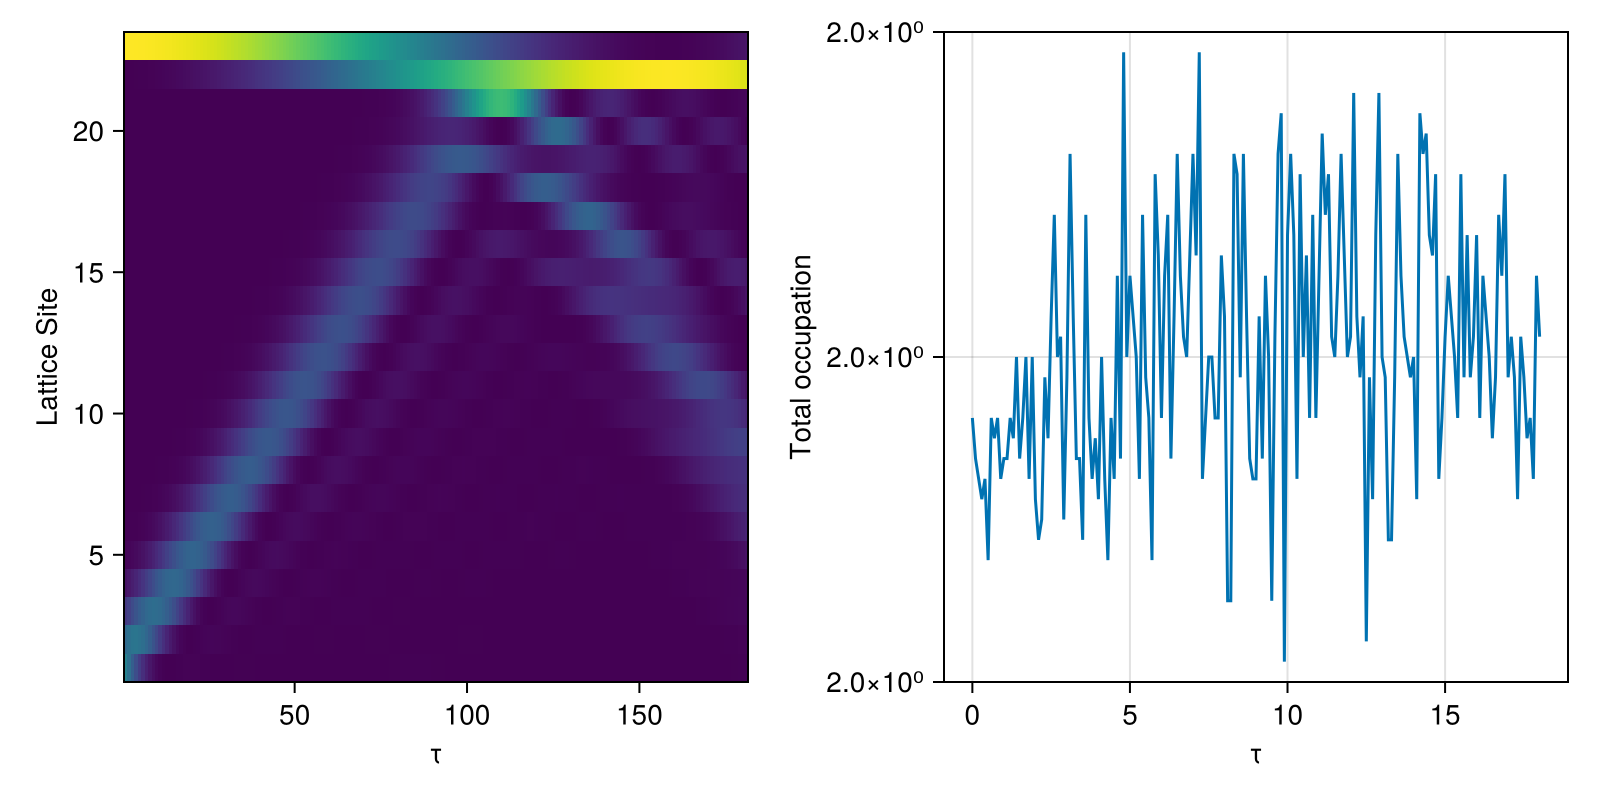

In [128]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Lattice Site")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Total occupation")

heatmap!(ax1, transpose(occupations_lin))
lines!(ax2, time_list, tot_occ)
f

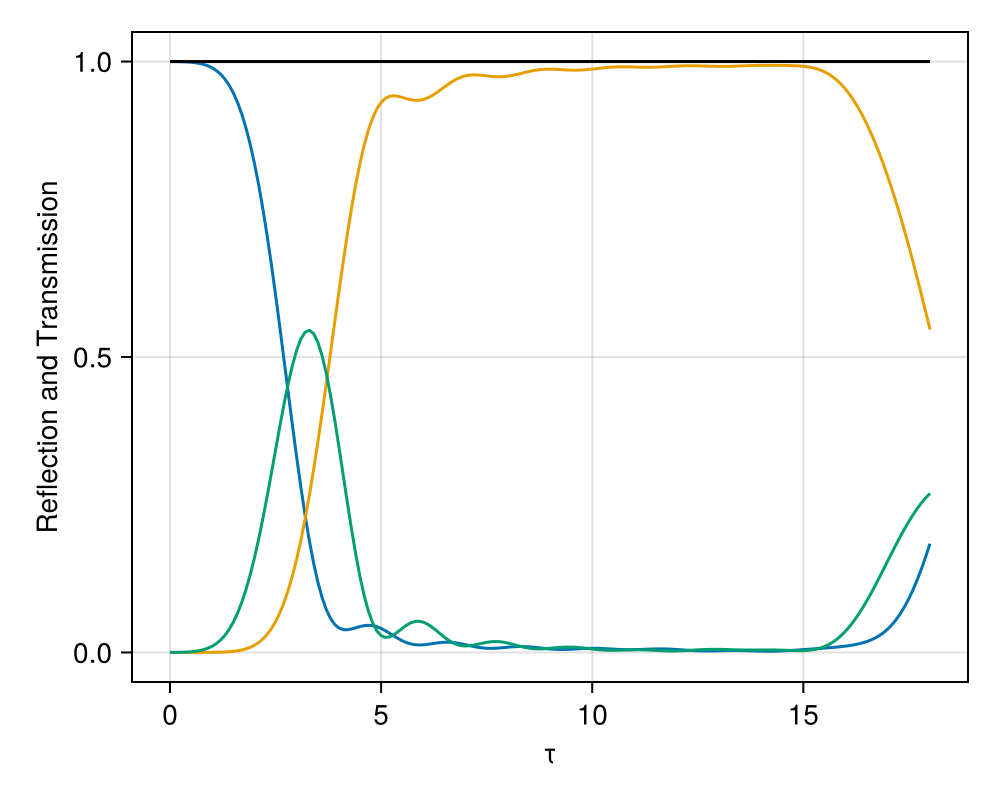

In [129]:
R_coeff = sum(occupations_lin[1:Bindex-2,:], dims=1)[1:end];
T_coeff = sum(occupations_lin[Bindex+1:end-2,:], dims=1)[1:end];
B_coeff = sum(occupations_lin[Bindex-1:Bindex,:], dims=1)[1:end];


f = Figure(size = (500, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Reflection and Transmission")

lines!(ax1,time_list, R_coeff)
lines!(ax1,time_list, T_coeff)
lines!(ax1,time_list, B_coeff)
lines!(ax1,time_list, R_coeff+ T_coeff+ B_coeff, color=:Black)
f


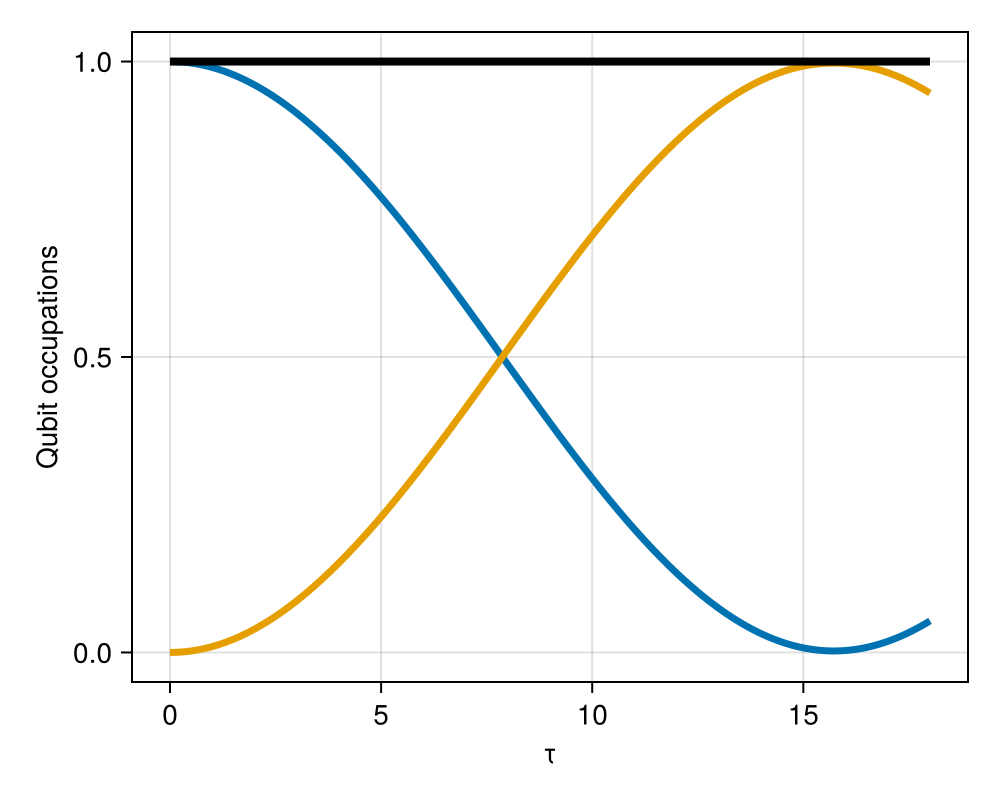

In [137]:
f = Figure(size = (500, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Qubit occupations")

lines!(ax1,time_list, occupations_lin[end,1:end], linewidth=3.5)
lines!(ax1,time_list, occupations_lin[end-1,1:end],linewidth=3.5)
lines!(ax1,time_list, occupations_lin[end,1:end] + occupations_lin[end-1,1:end], 
        color=:Black,linewidth=4)

ylims!(ax1, -0.05, 1.05)  # xmin, xmax, ymin, ymax


ax1
f

## Entropy and bond dimension

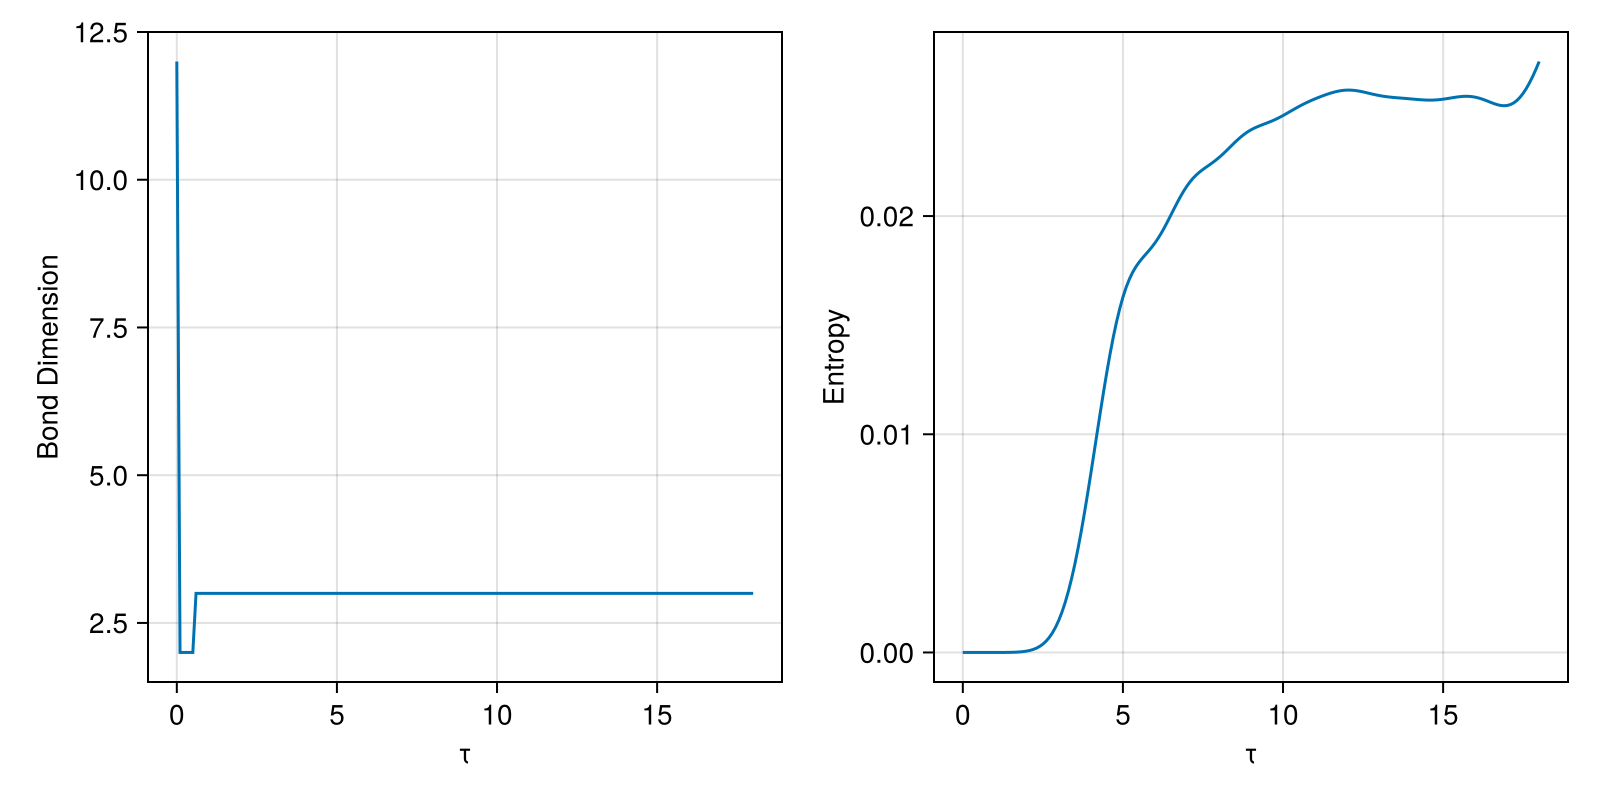

In [138]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Bond Dimension")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Entropy")

lines!(ax1, time_list, bond_dimensions)
lines!(ax2, time_list,entropies./log(2))

f


## Bloch Sphere

In [147]:
cosθ_list = []
sinϕtlist = []
θt_list = []

for i in 1:length(density_matrices[1,1,:])
    ρt = density_matrices[:,:,i]
    cosθt = 2*ρt[1,1] - 1
    θt = acos(cosθt)
    sinϕt = (ρt[2,1] - ρt[1,2])/(1im*sin(θt))
    
    push!(cosθ_list, cosθt)
    push!(sinϕtlist, sinϕt)
    push!(θt_list, θt)
    
end

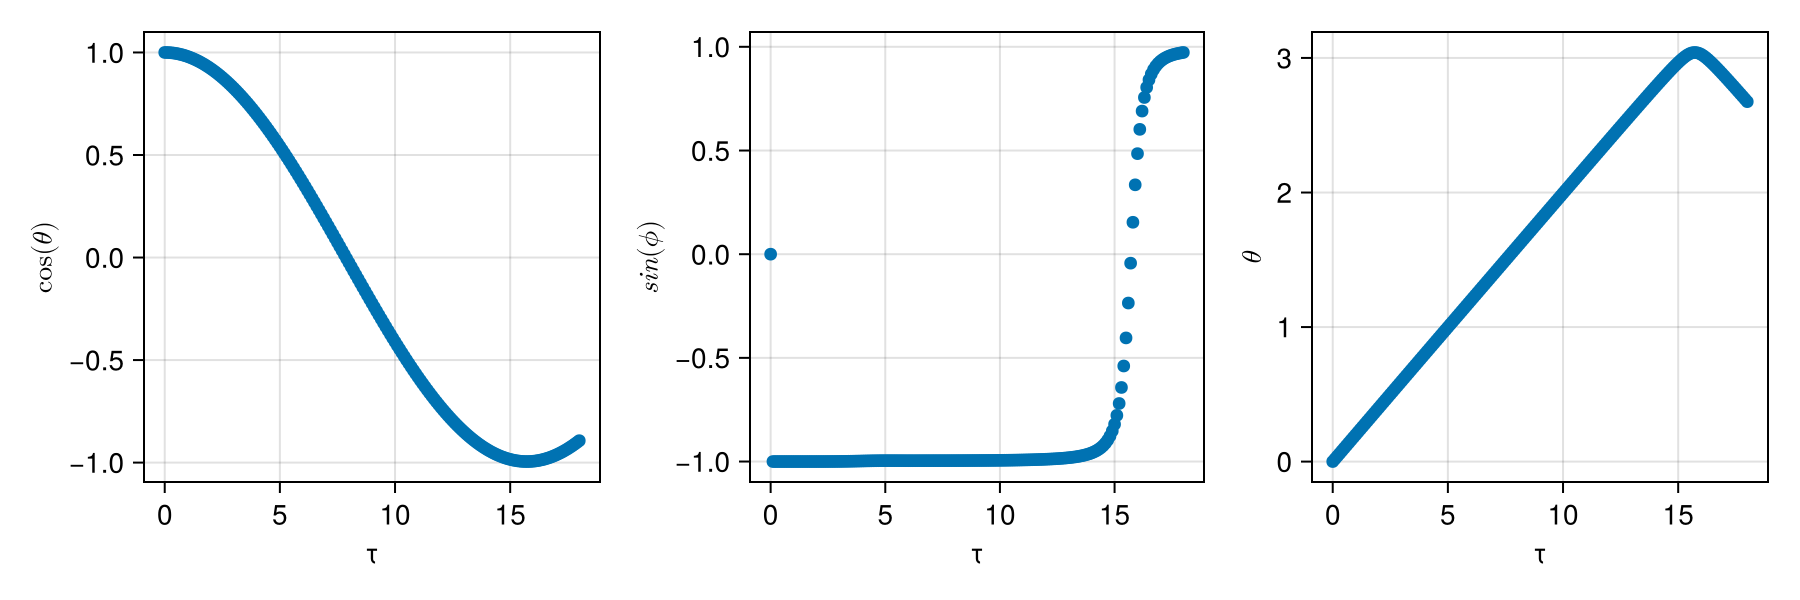

In [151]:
f = Figure(size = (900, 300))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel=L"\cos(\theta)")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel=L"sin(\phi)")
ax3 = Axis(f[1, 3], xlabel="τ", ylabel=L"\theta")

scatter!(ax1, time_list, real(cosθ_list))
scatter!(ax2, time_list, real(sinϕtlist))
scatter!(ax3, time_list, real(θt_list))

f